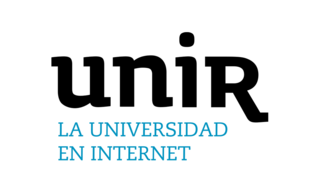

_Máster Universitario en Inteligencia Artificial_

_Trabajo Fin de Máster_

- Gustavo Mateos Santos
- gustavo.mateos830@comunidadunir.net

# Clasificación automática de estrellas variables con modelos Transformer aplicados a series temporales



In [ ]:
# Install missing packages
%pip install torch lightkurve
%pip install -q pyarrow

In [3]:
import torch, lightkurve as lk

print("Torch:", torch.__version__)
print("Lightkurve:", lk.__version__)

Torch: 2.2.2
Lightkurve: 2.5.0


## **Fase 2: Diseño e Implementación del Modelo Transformer**



## **NUEVO CICLO DE ENTRENAMIENTO+FINE-TUNING REDUCIENDO A 6 CLASES (CATACLYSMIC FUERA)**

Último ciclo de pruebas: después de llegar al mejor modelo en `17_preprocesado_training_finetuning_YSO_curated.ipynb`, vamos a realizar una prueba eliminando la clase *Cataclysmic*.

#### 1. **PREPROCESADO**

In [1]:
import warnings
import numpy as np
import sys
from pathlib import Path

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

# Ignorar solo los RuntimeWarning de numpy (como overflows en reduce)
warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy")

from src.fase2.script_1_transformer_preprocessing_optimizado_2 import main as preprocessing_optimized_YSO_cleaning

# Balanceo de clases 
max_per_class_override={
    "Irregular": 9000,
    "Rotational": 9000,
    "Eclipsing Binary": 9000,
    "Delta Scuti": None,            # 7.550 → TODAS
    "RR Lyrae": 9000,               # 41.208 → RECORTAMOS A 9.000
    "Young Stellar Object": None,   # 9.809 → TODAS 
    "Cataclysmic": 0,               # 0 → LA ELIMINAMOS!!
    "White Dwarf": 0,               # 0 → LA ELIMINAMOS
    "Variable": 0                   # 0 → LA ELIMINAMOS
}

# El script se ha adaptado para filtrar curvas malas directamente con el parametro `filtrar_curvas_malas`
preprocessing_optimized_YSO_cleaning(
    seq_length=25000,
    max_per_class=None, # usamos override completo
    max_per_class_override=max_per_class_override,
    parquet_batch_size=10_000_000,
    dataloader_batch_size=128,
    num_workers=20,
    filtrar_curvas_malas="../data/train/curvas_a_eliminar_por_confusion_yso.csv"
    #errores_csv_path=Path("../outputs/errores_mal_clasificados.csv")
)

📂 Cargando datos en lotes con PyArrow...
📂 [INFO] IDs a excluir por filtrado: 1288
📂 [INFO] Exclusiones por clase: {'Cataclysmic': 195, 'Delta Scuti': 97, 'Eclipsing Binary': 238, 'Irregular': 57, 'RR Lyrae': 101, 'Rotational': 170, 'Young Stellar Object': 430}
⏳ [INFO] Iniciando agrupación de curvas por objeto...


Agrupando curvas por objeto: 63batch [11:39, 11.10s/batch]

⏳ [INFO] Agrupación finalizada en 11 minutos y 39.3 segundos
📈 [INFO] Total de objetos agrupados: 52920


💾 [INFO] Agrupación guardada en cache: /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../data/train/grouped_data.pkl
⏳ [INFO] Tiempo en agrupación de datos: 708.9 segundos
🚀 Procesando 52920 curvas en paralelo usando 20 CPUs...
⏳ [INFO] Tiempo en procesamiento paralelo: 66.5 segundos
🔋 [INFO] Curvas válidas tras filtrado: 52827
🔎 Ejemplos aleatorios después del filtrado final:
ID: ASASSN-V J001514.85+613131.0, Clase: Young Stellar Object
ID: ASASSN-V J023056.44-164442.8, Clase: Delta Scuti
ID: 359519, Clase: Young Stellar Object
ID: ASASSN-V J024438.89+620300.0, Clase: Young Stellar Object
ID: ASASSN-V J003105.22+564200.4, Clase: Young Stellar Object

🔍 Realizando prueba rápida en características auxiliares...
✅ Sample 0 sin problemas: [-0.54644204 -0.45643937 -0.58532422 -1.16508518 -0.47457623  0.20024233
 -0.09739539]
✅ Sample 1 sin problemas: [ 0.04261633  0.21022727  0.02218427  0.27999178  0.21186437  0.53871293
 -0.06297631]
✅ Sample 2 sin problemas: [ 1.09325984  1.821

(<torch.utils.data.dataloader.DataLoader at 0x7fdca3f70c10>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdca3f70250>)

### **Verificaciones...**

In [1]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.serialization
from torch.utils.data import DataLoader
import sys
import gc
import os
import argparse
import warnings
from pathlib import Path

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

# Ignorar solo los RuntimeWarning de numpy (como overflows en reduce)
warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy")

from src.fase2.script_2_transformer_fine_tuning_optimizado import AstroConformerClassifier as AstroConformerClassifier, evaluate

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# acciones para resolver los problemas de memoria
# 1. Liberar memoria
gc.collect()
torch.cuda.empty_cache()

# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.backends.cudnn.benchmark = True

def detectar_todos_los_errores(preds, true, ids, label_encoder):
    """
    Retorna un DataFrame con todos los errores de clasificación con clase real y predicha bien decodificadas.
    """
    df_labels = pd.DataFrame({
        "id_objeto": ids,
        "true_label": true,
        "pred_label": preds
    })

    # Decodificar nombres
    label_decoder = {v: k for k, v in label_encoder.items()}
    df_labels["clase_real"] = df_labels["true_label"].map(label_decoder)
    df_labels["clase_predicha"] = df_labels["pred_label"].map(label_decoder)

    # Filtrar errores
    df_errores = df_labels[df_labels["clase_real"] != df_labels["clase_predicha"]][
        ["id_objeto", "clase_real", "clase_predicha"]
    ].reset_index(drop=True)

    return df_errores

def detectar_yso_confundidas(preds, true, ids, label_encoder):
    """
    Retorna un DataFrame con los objetos cuya clase fue predicha como YSO pero no lo eran.
    """
    df_labels = pd.DataFrame({
        "id_objeto": ids,
        "true_label": true,
        "pred_label": preds
    })

    label_decoder = {v: k for k, v in label_encoder.items()}
    df_labels["clase_real"] = df_labels["true_label"].map(label_decoder)
    df_labels["clase_predicha"] = df_labels["pred_label"].map(label_decoder)

    df_yso_mal = df_labels[
        (df_labels["clase_predicha"] == "Young Stellar Object") &
        (df_labels["clase_real"] != "Young Stellar Object")
    ][["id_objeto", "clase_real", "clase_predicha"]].reset_index(drop=True)

    return df_yso_mal


# Cargar dataset y label encoder
from src.fase2.script_1_transformer_preprocessing_optimizado_2 import LightCurveDataset
#torch.serialization.add_safe_globals([LightCurveDataset])

val_dataset = torch.load("../data/train/val_dataset.pt", weights_only=False)

# Verificacion rapida
# Cargar un sample cualquiera
sample = val_dataset[0]
# Ver cuántos elementos contiene
print("Nº de elementos devueltos por __getitem__:", len(sample))
# Inspeccionar los elementos
for i, item in enumerate(sample):
    print(f"Elemento {i}: {type(item)}, shape o valor: {getattr(item, 'shape', item)}")

with open("../data/train/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)
num_classes = len(label_encoder)
class_names = list(label_encoder.keys())

# Dataloader con batch pequeño
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=6, pin_memory=True, persistent_workers=True)

# Crear el modelo con la arquitectura esperada
args = argparse.Namespace(
    input_dim=1,
    in_channels=1,
    encoder_dim=256,
    hidden_dim=384,
    output_dim=num_classes,
    num_heads=8,
    num_layers=8,
    dropout=0.4, dropout_p=0.4,
    stride=32,
    kernel_size=3,
    norm="postnorm",
    encoder=["mhsa_pro", "conv", "conv"],
    timeshift=False,
    device=device
)
model = AstroConformerClassifier(args, num_classes=len(label_encoder), feature_dim=7)

# Cargar los pesos entrenados
state_dict = torch.load("../outputs/mejor_modelo_finetuned_optimizado2_features_segunda_vuelta.pt", map_location="cpu")
# Elimina el prefijo "_orig_mod." de las claves
new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)

# Pasar a GPU si está disponible
model = model.to(device)
model.eval()  # Muy importante: modo evaluación

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluar con IDs
val_loss, preds, true, ids = evaluate(model, val_loader, criterion, device)

#####################################
# Mostrar el label encoder para asegurar consistencia (opcional si ya lo hiciste)
print("Contenido del label encoder:")
for key, value in label_encoder.items():
    print(f"{key}: {value}")
# Mapear IDs a clases reales desde el CSV original
df_debug = pd.read_csv("../data/train/debug_clases_codificadas.csv")
dict_clases_reales = dict(zip(df_debug["id"].astype(str), df_debug["clase_variable"]))
print("\n🔍 Verificación manual de los primeros errores:")
for i in range(5):
    pred_label = class_names[preds[i]]
    true_label = class_names[true[i]]
    object_id = str(ids[i])

    real_ref = dict_clases_reales.get(object_id, "NO_ENCONTRADO")

    print(f"ID: {object_id}")
    print(f" - Predicha: {pred_label}")
    print(f" - Real (según modelo): {true_label}")
    print(f" - Real (en CSV original): {real_ref}")
    print("---")
#####################################

# Detectar YSO mal clasificadas
df_yso_mal = detectar_yso_confundidas(preds, true, ids, label_encoder)
df_yso_mal.to_csv("../outputs/yso_clase_predicha_error2.csv", index=False)
# Detectar todos los errores
df_todos_errores = detectar_todos_los_errores(preds, true, ids, label_encoder)
df_todos_errores.to_csv("../outputs/todos_los_errores2.csv", index=False)

print(f"YSOs mal clasificadas detectadas: {len(df_yso_mal)}")
print(f"Total de errores detectados: {len(df_todos_errores)}")


Matplotlib is building the font cache; this may take a moment.


Nº de elementos devueltos por __getitem__: 5
Elemento 0: <class 'torch.Tensor'>, shape o valor: torch.Size([25000])
Elemento 1: <class 'torch.Tensor'>, shape o valor: torch.Size([])
Elemento 2: <class 'torch.Tensor'>, shape o valor: torch.Size([25000])
Elemento 3: <class 'torch.Tensor'>, shape o valor: torch.Size([7])
Elemento 4: <class 'str'>, shape o valor: ASASSN-V J000630.82+760758.8


RuntimeError: Error(s) in loading state_dict for AstroConformerClassifier:
	size mismatch for classifier.3.weight: copying a param with shape torch.Size([7, 256]) from checkpoint, the shape in current model is torch.Size([6, 256]).
	size mismatch for classifier.3.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([6]).

In [2]:
# Ejemplo para comprobar el contenido de un dataset .pt
import torch
import sys
from pathlib import Path

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
    
# Cargar el dataset (ajusta la ruta si es necesario)
dataset = torch.load("../data/train/train_dataset.pt", weights_only=False)

# Obtener el primer elemento
sample = dataset[0]

# Mostrar información de cada campo
for i, value in enumerate(sample):
    print(f"Elemento {i}: tipo={type(value)}, valor/shape={getattr(value, 'shape', value)}")

# Ejemplo de salida esperada:
# Elemento 0: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([25000])
# Elemento 1: tipo=<class 'torch.Tensor'>, valor/shape=tensor(3)
# Elemento 2: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([25000])
# Elemento 3: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([7])
# Elemento 4: tipo=<class 'str'>, valor/shape=ASASSN-V J055358.70+014409.5

Elemento 0: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([25000])
Elemento 1: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([])
Elemento 2: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([25000])
Elemento 3: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([7])
Elemento 4: tipo=<class 'str'>, valor/shape=ASASSN-V J031246.49-175457.5


In [ ]:
import pandas as pd

# Cargar ambos archivos
df_errores = pd.read_csv("../outputs/todos_los_errores2.csv")
df_ref = pd.read_csv("../data/train/debug_clases_codificadas.csv")

# Renombrar para evitar conflictos
df_ref = df_ref.rename(columns={"id": "id_objeto", "clase_variable": "clase_real_ref"})

# ⚠️ Filtrar solo errores cuyos IDs aún están en el dataset final
df_errores_filtrados = df_errores[df_errores["id_objeto"].isin(df_ref["id_objeto"])].copy()

# Cruzar por ID
df_merge = pd.merge(df_errores_filtrados, df_ref, on="id_objeto", how="left")

# Verificar discrepancias REALES
df_discrepancias = df_merge[df_merge["clase_real"] != df_merge["clase_real_ref"]]

# Mostrar resumen
print(f"🔎 Total errores analizados: {len(df_errores_filtrados)} (de {len(df_errores)} totales)")
print(f"❌ Discrepancias reales: {len(df_discrepancias)}")
if not df_discrepancias.empty:
    print(df_discrepancias.head(10))


In [3]:
import torch

# Cargar dataset
val_dataset = torch.load("../data/train/val_dataset.pt", weights_only=False)

# Elegir IDs concretos con discrepancias
ids_problema = [
    "ASASSN-V J024305.65-065501.3",
    "ASASSN-V J031438.40+581303.1",
    "ASASSN-V J093207.60-823329.8",
    "ASASSN-V J114016.78+184126.4",
    "459672",
    "ASASSN-V J002142.23-414002.5",
    "ASASSN-V J112416.67-110645.0",
    "ASASSN-V J032732.09+000351.4",
    "ASASSN-V J030537.58-593637.3",
    "AP43491782",
    "ASASSN-V J031510.38+545659.0",  # Clase: Rotational
    "ASASSN-V J025201.04-233827.4",  # Clase: Irregular
    "ASASSN-V J153259.00-332342.9",  # Clase: RR Lyrae
    "ASASSN-V J073526.05-305037.0"   # Clase: Delta Scuti
]
# Cargar CSV codificado
df_codificadas = pd.read_csv("../data/train/debug_clases_codificadas.csv")
df_codificadas = df_codificadas.set_index("id")

# Cargar encoder
import pickle
with open("../data/train/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)
inv_label_encoder = {v: k for k, v in label_encoder.items()}

# Buscar en val_dataset los objetos y verificar su label real
print("🔍 Verificación directa en dataset:")
for i in range(len(val_dataset)):
    _, label, _, _, id_obj = val_dataset[i]
    if id_obj in ids_problema:
        clase_real_dataset = inv_label_encoder[label.item()]
        clase_codificada_csv = df_codificadas.loc[id_obj, "clase_codificada"]
        clase_nombre_csv = df_codificadas.loc[id_obj, "clase_variable"]
        print(f"🧾 ID: {id_obj}")
        print(f" - Clase val_dataset: {clase_real_dataset}")
        print(f" - Clase CSV codificado: {clase_nombre_csv} ({clase_codificada_csv})")
        print("---")


🔍 Verificación directa en dataset:
🧾 ID: ASASSN-V J073526.05-305037.0
 - Clase val_dataset: Irregular
 - Clase CSV codificado: Irregular (2)
---
🧾 ID: 459672
 - Clase val_dataset: Rotational
 - Clase CSV codificado: Rotational (4)
---
🧾 ID: ASASSN-V J114016.78+184126.4
 - Clase val_dataset: Rotational
 - Clase CSV codificado: Rotational (4)
---
🧾 ID: ASASSN-V J153259.00-332342.9
 - Clase val_dataset: Eclipsing Binary
 - Clase CSV codificado: Eclipsing Binary (1)
---


### 2. **ENTRENAMIENTO**

Matplotlib is building the font cache; this may take a moment.


🔄 Restaurando datasets...
✅ Dataset cargado en 712.05 segundos
🔄 Cargando datasets completos...
Total batches in train_loader: 193
Total batches in val_loader: 56
✅ Comprobación completada
TOTAL CLASES: 6
🚀 Entrenando modelo optimizado...
AstroConformerClassifier(
  (encoder): Astroconformer(
    (extractor): Sequential(
      (0): Conv1d(1, 256, kernel_size=(32,), stride=(32,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
    (pe): RotaryEmbedding()
    (encoder): ConformerEncoder(
      (blocks): ModuleList(
        (0-7): 8 x ConformerBlock(
          (modlist): ModuleList(
            (0): PostNorm(
              (module): MHA_rotary(
                (query): Linear(in_features=256, out_features=256, bias=True)
                (key): Linear(in_features=256, out_features=256, bias=True)
                (value): Linear(in_features=256, out_features=256, bias=True)
                (rotary_emb): RotaryEmbedding()
  

Entrenamiento del modelo:   0%|          | 0/50 [00:00<?, ?it/s]

[TRAIN] TIEMPO ÉPOCA: 154.6594s
[VAL] TIEMPO ÉPOCA: 39.4623s

🧪 Epoch 1/50
Train loss: 1.7551, Val loss: 1.6170
Train acc: 0.2654, Val acc: 0.4204
💾 Guardado modelo mejorado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases.pt
[TRAIN] TIEMPO ÉPOCA: 132.3202s
[VAL] TIEMPO ÉPOCA: 38.5847s

🧪 Epoch 2/50
Train loss: 1.5961, Val loss: 1.4982
Train acc: 0.3993, Val acc: 0.4816
💾 Guardado modelo mejorado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases.pt
[TRAIN] TIEMPO ÉPOCA: 132.2574s
[VAL] TIEMPO ÉPOCA: 38.4469s

🧪 Epoch 3/50
Train loss: 1.4992, Val loss: 1.4234
Train acc: 0.4457, Val acc: 0.5054
💾 Guardado modelo mejorado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases.pt
[TRAIN] TIEMPO ÉPOCA: 132.2714s
[VAL] TIEMPO ÉPOCA: 38.5513s

🧪 Epoch 4/50
Train loss: 1.4355, Val loss: 1.3681
Train acc: 0.4779, Val acc: 0.5212
💾 Guardado mo

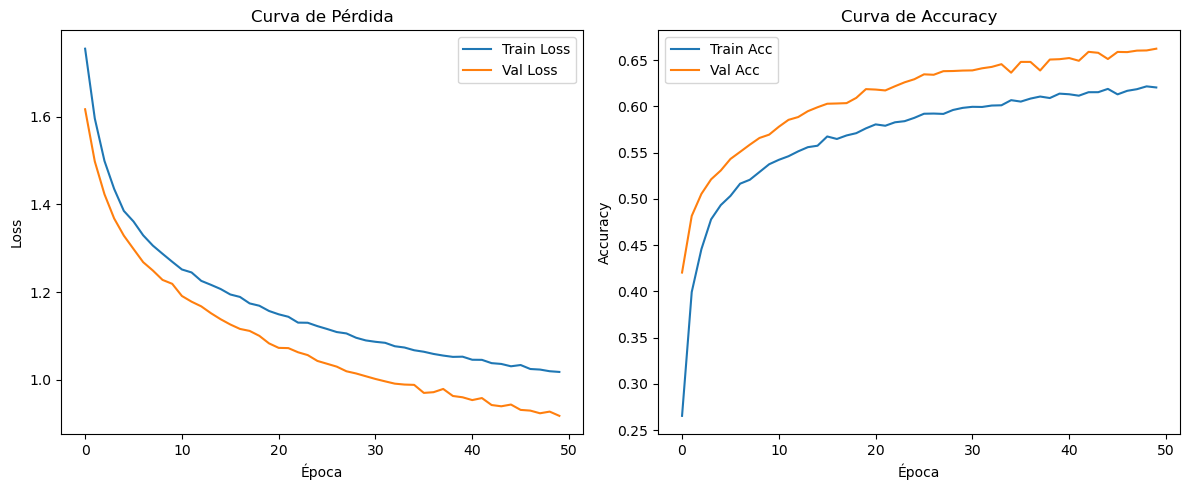


📊 Classification Report:
{'0': {'precision': 0.6400287976961843, 'recall': 0.6105769230769231, 'f1-score': 0.6249560632688927, 'support': 1456.0}, '1': {'precision': 0.700759789596727, 'recall': 0.6661111111111111, 'f1-score': 0.682996297351182, 'support': 1800.0}, '2': {'precision': 0.6925531914893617, 'recall': 0.7233333333333334, 'f1-score': 0.7076086956521739, 'support': 1800.0}, '3': {'precision': 0.7745398773006135, 'recall': 0.8416666666666667, 'f1-score': 0.8067092651757188, 'support': 1800.0}, '4': {'precision': 0.6151142355008787, 'recall': 0.5833333333333334, 'f1-score': 0.5988023952095808, 'support': 1800.0}, '5': {'precision': 0.5431841831425598, 'recall': 0.5468831849135674, 'f1-score': 0.5450274079874706, 'support': 1909.0}, 'accuracy': 0.6624704212020823, 'macro avg': {'precision': 0.6610300124543875, 'recall': 0.6619840920724892, 'f1-score': 0.6610166874408364, 'support': 10565.0}, 'weighted avg': {'precision': 0.6604979937588676, 'recall': 0.6624704212020823, 'f1-sco

In [ ]:
import sys
import torch
import pickle
from torch.utils.data import DataLoader
from pathlib import Path
import time
import os
import gc

gc.collect()
torch.cuda.empty_cache()
# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_2_transformer_training_optimizado2 import main as train_model_optimized_YSO_cleaning

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

print("🔄 Restaurando datasets...")
start = time.time()
train_dataset = torch.load("../data/train/train_dataset.pt")
val_dataset = torch.load("../data/train/val_dataset.pt")
print(f"✅ Dataset cargado en {time.time() - start:.2f} segundos")

# Cargar datasets completos
print("🔄 Cargando datasets completos...")
train_loader = DataLoader(train_dataset, batch_size=192, shuffle=True, num_workers=10, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=192, shuffle=False, num_workers=10, pin_memory=True)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")

######################################################################
# Crear un mini-dataloader con batch pequeño para inspección
batch_size = 256
debug_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
for i, (x, y, mask, features, ids) in enumerate(debug_loader):
    if i >= 100:
        break
    # Validaciones de tipo
    if not torch.is_tensor(x) or not torch.is_tensor(mask):
        print(f"❌ No tensor en entrada en batch {i}")
    if not torch.is_tensor(y) or not torch.is_tensor(features):
        print(f"❌ y o features no son tensores en batch {i}")
    # Validaciones de contenido
    if not torch.isfinite(x).all():
        print(f"⚠️ x contiene NaN o Inf en batch {i}")
    if not torch.isfinite(mask).all():
        print(f"⚠️ mask contiene NaN o Inf en batch {i}")
    if not torch.isfinite(features).all():
        print(f"⚠️ features contiene NaN o Inf en batch {i}:\n{features}")
    # Validación de forma
    if features.shape[1] != 7:
        print(f"❌ Tamaño inesperado en features en batch {i}: {features.shape}")
    if x.shape != mask.shape:
        print(f"❌ Tamaños incompatibles en batch {i}: x {x.shape}, mask {mask.shape}")
    # Validación de etiquetas
    for j, label in enumerate(y):
        if not isinstance(label.item(), int):
            print(f"❌ Etiqueta no entera en batch {i}, elemento {j}: {label}")
        if label.item() < 0 or label.item() >= 9:
            print(f"❌ Etiqueta fuera de rango en batch {i}, elemento {j}: {label.item()}")
print("✅ Comprobación completada")
######################################################################

# Calcular número de clases
label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"TOTAL CLASES: {num_classes}")

# Ejecutar entrenamiento optimizado: 
# Ponderación por clase con class_weight
# dropout=0.3
# Scheduler ReduceLROnPlateau
# Early stopping
# Curvas de pérdida y accuracy
print("🚀 Entrenando modelo optimizado...")
model = train_model_optimized_YSO_cleaning(
    train_loader=train_loader,
    val_loader=val_loader,
    label_encoder=label_encoder,
    device=device,
    epochs=50,
    lr=3e-5,
    freeze_encoder=True,  # transfer learning clásico
    patience=6,           # early stopping
    debug=False,          # True para depuración
    model_name="mejor_modelo_optimizado_6_clases.pt"  # Nuevo argumento opcional
)

### 3. **FINE TUNING 1/2**

🔄 Restaurando datasets...
🔄 Cargando datasets completos...
Total batches in train_loader: 578
Total batches in val_loader: 166
NUM CLASES: 6
🚀 Fine-tuning sobre mejor modelo optimizado...
✅ Modelo base cargado desde /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases.pt
Modelo en: cuda:0


Fine-tuning:   0%|          | 0/40 [00:00<?, ?it/s]

⏱️ Tiempo entrenamiento: 193.28s
🔍 Tiempo evaluación: 45.87s

🧪 Epoch 1/40
Train loss: 1.0729, Val loss: 0.9279
Train acc: 0.5998, Val acc: 0.6576
💾 Guardado mejor modelo fine-tuned en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases_fine_tuned.pt
⏱️ Tiempo época: 239.19s
🔓 Encoder descongelado y optimizador actualizado en epoch 2
⏱️ Tiempo entrenamiento: 88.17s
🔍 Tiempo evaluación: 26.07s

🧪 Epoch 2/40
Train loss: 1.0649, Val loss: 0.9217
Train acc: 0.6032, Val acc: 0.6593
💾 Guardado mejor modelo fine-tuned en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases_fine_tuned.pt
⏱️ Tiempo época: 114.33s
⏱️ Tiempo entrenamiento: 88.38s
🔍 Tiempo evaluación: 26.16s

🧪 Epoch 3/40
Train loss: 1.0547, Val loss: 0.9478
Train acc: 0.6055, Val acc: 0.6423
⏱️ Tiempo época: 114.54s
⏱️ Tiempo entrenamiento: 88.25s
🔍 Tiempo evaluación: 26.14s

🧪 Epoch 4/40
Train loss: 1.0446, Val loss: 0.9067
Train acc: 

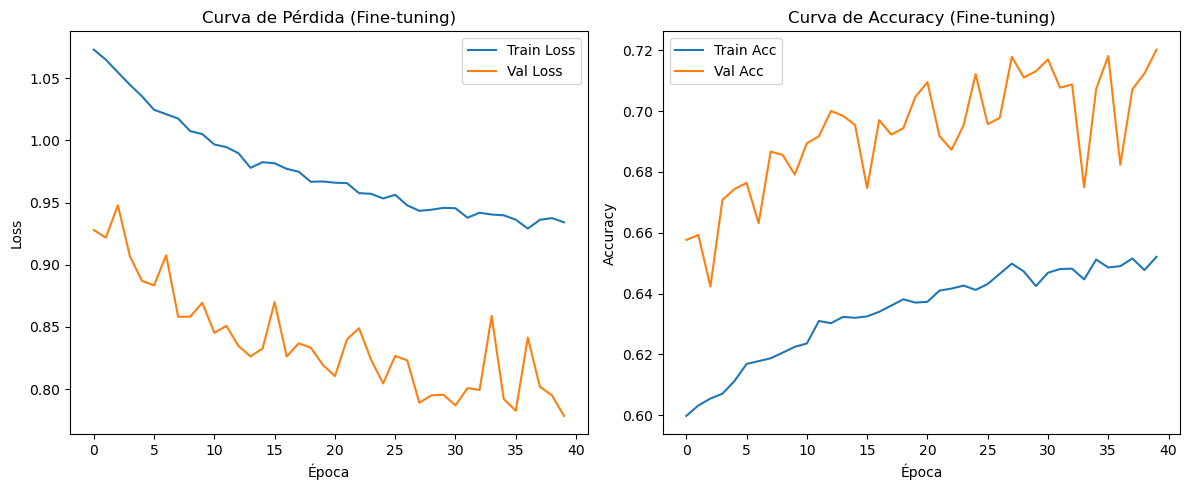

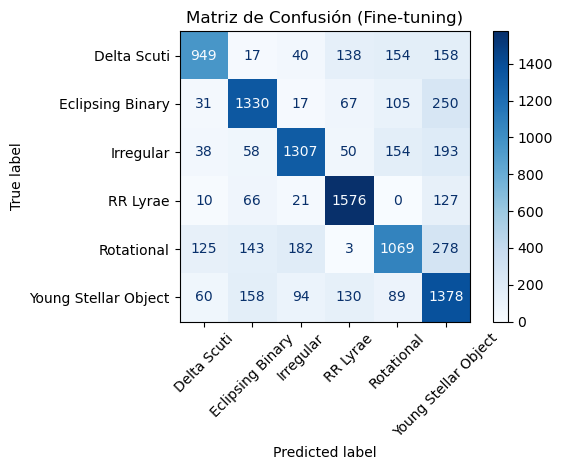

💾 Guardado CSV con errores: /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases_fine_tuned_errores_clasificacion.csv
📄 Reporte de clasificación guardado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases_fine_tuned_class_report.csv
⚠️ Detected _orig_mod. prefix in state_dict. Stripping prefixes...


/home/ec2-user/SageMaker/astro_transformer/Astroconformer/Astroconformer/Model/Modules/mhsa_pro.py:108: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  cos, sin = RoPE
/home/ec2-user/SageMaker/astro_transformer/Astroconformer/Astroconformer/Model/Modules/mhsa_pro.py:113: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))                 # self-attention: (B, nh, T, hs) * (B, nh, hs, T) -> (B, nh, T, T)


✅ Modelo exportado a ONNX en: /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases_fine_tuned.onnx


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/onnx/utils.py:1703: UserWarning: The exported ONNX model failed ONNX shape inference. The model will not be executable by the ONNX Runtime. If this is unintended and you believe there is a bug, please report an issue at https://github.com/pytorch/pytorch/issues. Error reported by strict ONNX shape inference: [ShapeInferenceError] (op_type:Einsum, node name: /pe/Einsum): Inputs has inconsistent type tensor(float) (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/torch/csrc/jit/serialization/export.cpp:1484.)
  _C._check_onnx_proto(proto)


In [1]:
import torch
from torch.utils.data import DataLoader
import pickle
import os
import torch, gc
import sys
from pathlib import Path
import numpy as np

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_2_transformer_fine_tuning_optimizado import main as fine_tuned_optimized_model

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# acciones para resolver los problemas de memoria
# 1. Liberar memoria
gc.collect()
torch.cuda.empty_cache()

# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.backends.cudnn.benchmark = True

print("🔄 Restaurando datasets...")
train_dataset = torch.load("../data/train/train_dataset.pt")
val_dataset = torch.load("../data/train/val_dataset.pt")

# Cargar datasets completos
print("🔄 Cargando datasets completos...")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=12, pin_memory=True)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")

label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"NUM CLASES: {num_classes}")

# Fine-tuning optimizado
# Carga desde mejor_modelo_optimizado.pt
# Doble learning rate (encoder / head)
# Descongelado tras las primeras n epocas (freeze_epochs=n) o desde el principio (con freeze_encoder=False)
# label_smoothing=0.1 para mejorar la generalización (lo hemos quitado en esta prueba)
# Optimización por AdamW con weight_decay.
print("🚀 Fine-tuning sobre mejor modelo optimizado...")
model = fine_tuned_optimized_model(
    train_loader=train_loader,
    val_loader=val_loader,
    label_encoder=label_encoder,
    model_name_in="mejor_modelo_optimizado_6_clases.pt",  # El que se ha generado en el entrenamiento anterior
    model_name_out=None,  # Lo guarda como {model_name_in}_fine_tuned.pt, se le pasará al fine tuning siguiente
    device=device,
    epochs=40,
    patience=5,
    # freeze_encoder=False,
    freeze_epochs=2,
    encoder_lr=3e-6,
    head_lr=1e-4,  # Para acelerar la adaptación de la capa final
    gamma=3,
    use_scheduler=True,  # Usar scheduler ReduceLROnPlateau
)

### 4. **FINE TUNING 2/2**

🔄 Restaurando datasets...
🔄 Cargando datasets completos...
Total batches in train_loader: 771
Total batches in val_loader: 221
NUM CLASES: 6
🚀 Fine-tuning sobre mejor modelo optimizado...
⚠️ Detected _orig_mod. prefix in state_dict. Stripping prefixes...
✅ Modelo base cargado desde /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases_fine_tuned.pt
Modelo en: cuda:0


Fine-tuning:   0%|          | 0/15 [00:00<?, ?it/s]

⏱️ Tiempo entrenamiento: 528.49s
🔍 Tiempo evaluación: 50.75s

🧪 Epoch 1/15
Train loss: 0.8751, Val loss: 0.7096
Train acc: 0.6739, Val acc: 0.7393
💾 Guardado mejor modelo fine-tuned en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases_fine_tuned_2.pt
⏱️ Tiempo época: 579.29s
⏱️ Tiempo entrenamiento: 296.31s
🔍 Tiempo evaluación: 24.22s

🧪 Epoch 2/15
Train loss: 0.8057, Val loss: 0.6779
Train acc: 0.7017, Val acc: 0.7460
💾 Guardado mejor modelo fine-tuned en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases_fine_tuned_2.pt
⏱️ Tiempo época: 320.62s
⏱️ Tiempo entrenamiento: 296.22s
🔍 Tiempo evaluación: 24.24s

🧪 Epoch 3/15
Train loss: 0.7806, Val loss: 0.6829
Train acc: 0.7130, Val acc: 0.7462
⏱️ Tiempo época: 320.46s
⏱️ Tiempo entrenamiento: 296.26s
🔍 Tiempo evaluación: 24.32s

🧪 Epoch 4/15
Train loss: 0.7510, Val loss: 0.6415
Train acc: 0.7237, Val acc: 0.7626
💾 Guardado mejor modelo fine-

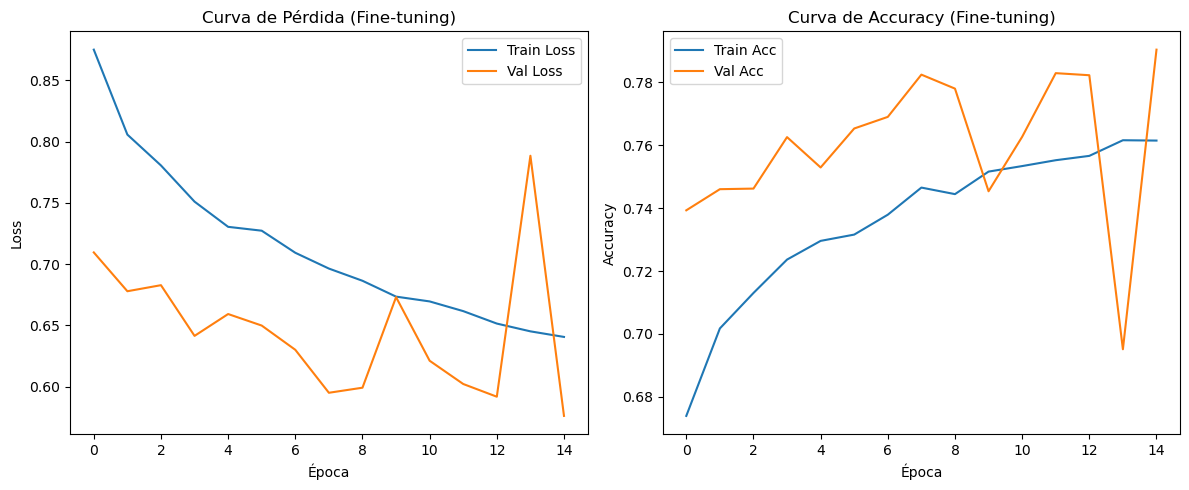

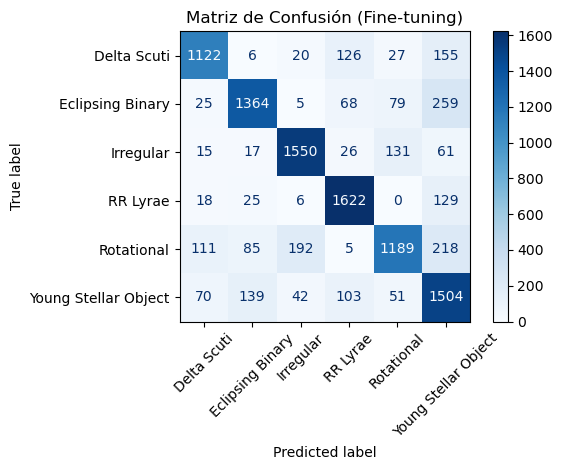

💾 Guardado CSV con errores: /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases_fine_tuned_2_errores_clasificacion.csv
📄 Reporte de clasificación guardado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases_fine_tuned_2_class_report.csv
⚠️ Detected _orig_mod. prefix in state_dict. Stripping prefixes...


/home/ec2-user/SageMaker/astro_transformer/Astroconformer/Astroconformer/Model/Modules/mhsa_pro.py:108: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  cos, sin = RoPE
/home/ec2-user/SageMaker/astro_transformer/Astroconformer/Astroconformer/Model/Modules/mhsa_pro.py:113: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))                 # self-attention: (B, nh, T, hs) * (B, nh, hs, T) -> (B, nh, T, T)


✅ Modelo exportado a ONNX en: /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_6_clases_fine_tuned_2.onnx


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/onnx/utils.py:1703: UserWarning: The exported ONNX model failed ONNX shape inference. The model will not be executable by the ONNX Runtime. If this is unintended and you believe there is a bug, please report an issue at https://github.com/pytorch/pytorch/issues. Error reported by strict ONNX shape inference: [ShapeInferenceError] (op_type:Einsum, node name: /pe/Einsum): Inputs has inconsistent type tensor(float) (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/torch/csrc/jit/serialization/export.cpp:1484.)
  _C._check_onnx_proto(proto)


In [1]:
import torch
from torch.utils.data import DataLoader
import pickle
import os
import torch, gc
import sys
from pathlib import Path
import numpy as np

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_2_transformer_fine_tuning_optimizado import main as fine_tuned_optimized_model

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# acciones para resolver los problemas de memoria
# 1. Liberar memoria
gc.collect()
torch.cuda.empty_cache()

# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.backends.cudnn.benchmark = True

print("🔄 Restaurando datasets...")
train_dataset = torch.load("../data/train/train_dataset.pt")
val_dataset = torch.load("../data/train/val_dataset.pt")

# Cargar datasets completos
print("🔄 Cargando datasets completos...")
train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=12, pin_memory=True,persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=48, shuffle=False, num_workers=12, pin_memory=True,persistent_workers=True)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")

label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"NUM CLASES: {num_classes}")

# Fine-tuning adicional
# Carga desde mejor_modelo_optimizado.pt
# Doble learning rate (encoder / head)
# Descongelado tras las primeras n epocas (freeze_epochs=n) o desde el principio (con freeze_encoder=False)
# Usar scheduler ReduceLROnPlateau
# Optimización por AdamW con weight_decay.
print("🚀 Fine-tuning sobre mejor modelo optimizado...")
model = fine_tuned_optimized_model(
    train_loader=train_loader,
    val_loader=val_loader,
    model_name_in="mejor_modelo_optimizado_6_clases_fine_tuned.pt",    # <= El generado en el fine tuning anterior
    model_name_out="mejor_modelo_optimizado_6_clases_fine_tuned_2.pt",
    label_encoder=label_encoder,
    device=device,
    epochs=15,
    patience=5,
    freeze_encoder=False,
    #freeze_epochs=2,
    encoder_lr=2e-6,
    head_lr=5e-6,
    gamma=3,
    use_scheduler=True,  # Usar scheduler ReduceLROnPlateau
)

| Clase                | Precisión (7 cls) | Precisión (6 cls) | Recall (7 cls) | Recall (6 cls) | F1-score (7 cls) | F1-score (6 cls) |
|----------------------|------------------|-------------------|----------------|----------------|------------------|------------------|
| Delta Scuti          | 0.74             | 0.77              | 0.72           | 0.73           | 0.73             | 0.75             |
| Eclipsing Binary     | 0.76             | 0.77              | 0.74           | 0.78           | 0.75             | 0.77             |
| Irregular            | 0.74             | 0.75              | 0.78           | 0.79           | 0.76             | 0.77             |
| RR Lyrae             | 0.78             | 0.81              | 0.82           | 0.84           | 0.80             | 0.82             |
| Rotational           | 0.64             | 0.68              | 0.55           | 0.66           | 0.59             | 0.67             |
| Young Stellar Object | 0.69             | 0.67              | 0.75           | 0.79           | 0.72             | 0.73             |

**Comparativa de métricas** (precision, recall, f1-score) por clase entre los dos modelos:

- ✅ Delta Scuti mejora en precisión (de 0.72 → 0.77) y f1-score, aunque se mantiene en recall.
- ✅ Eclipsing Binary mejora en todas las métricas: f1-score sube de 0.77 a 0.79.
- ⚖️ Irregular mantiene valores similares, con ligera mejora en recall y ligera pérdida en precisión.
- ✅ RR Lyrae mejora en precisión (de 0.78 → 0.81), y en recall.
- ✅ Rotational mejora drástica en recall (de 0.55 → 0.66) y f1-score (de 0.59 → 0.67).

| Clase                    | Mejora observable con 6 clases                   |
| ------------------------ | ------------------------------------------------ |
| **Delta Scuti**          | ✅ Mejora en precisión y F1                       |
| **Eclipsing Binary**     | ✅ Mejora en recall y F1                          |
| **Irregular**            | ⚖️ Estabilidad, métricas similares               |
| **RR Lyrae**             | ✅ Fuerte mejora en precisión                     |
| **Rotational**           | ✅ Gran mejora en recall (0.55 → 0.66)            |
| **Young Stellar Object** | ⚖️ Ligera pérdida en precisión, mejora en recall |


**Matriz de Confusión**:

- Rotational:
    - Antes: dispersión importante hacia Delta Scuti, Eclipsing Binary e Irregular.
    - Después: mejora en concentración, aunque persisten errores, especialmente con Irregular.

- Young Stellar Object:
    - Antes: confundido con RR Lyrae y Delta Scuti.
    - Después: más concentración en la diagonal y reducción de errores hacia Rotational.

- Cataclysmic:
    - En el modelo anterior, esta clase tenía alta confusión con Young Stellar Object y RR Lyrae, con apenas 124 predicciones correctas. Su presencia inducía errores en otras clases.

Correcto: tu análisis es preciso y plantea una **duda legítima sobre la conveniencia de eliminar la clase ‘Cataclysmic’**. Aquí tienes una síntesis crítica con todos los elementos clave para decidir qué versión defender en la memoria del TFM:


---

#### 🔍 Comparativa final: ¿Justifica la reducción de clases a 6?

| Aspecto                    | Modelo con 7 clases                  | Modelo con 6 clases | Observaciones                                                |
| -------------------------- | ------------------------------------ | ------------------- | ------------------------------------------------------------ |
| **Accuracy de validación** | ≈ 0.78                               | ≈ 0.79              | Mejora leve, pero no significativa                           |
| **F1-score medio**         | 0.73                                 | 0.75                | Subida global moderada                                       |
| **Casos mal clasificados** | **2.695 errores**                    | **2.957 errores**   | Aumentan los errores pese a eliminar una clase problemática  |
| **Rotational (F1)**        | 0.59                                 | **0.67**            | Una de las mejoras más claras                                |
| **YSO (F1)**               | **0.72**                             | 0.73                | Prácticamente idéntico                                       |
| **RR Lyrae (F1)**          | 0.80                                 | **0.82**            | Mejora sólida, aunque ya era alta                            |
| **Cataclysmic**            | 0.37 (F1 bajo, confusión con YSO/EB) | Eliminada           | Tenía bajo rendimiento, pero se gestionaba como clase aparte |


1. **No hay mejora global contundente**:

   * La ligera ganancia en accuracy y F1 no compensa claramente el aumento de errores absolutos ni justifica por sí sola la reducción de clases.

2. **Se pierde valor semántico**:

   * Al eliminar *Cataclysmic*, se sacrifica una clase científicamente relevante, aunque minoritaria.

3. **Podría haber alternativas mejores**:

   * En lugar de eliminarla, se podría:

     * fusionar con otra clase afín (e.g., YSO o Variable),
     * mejorar su entrenamiento con más curvas (data augmentation, refuerzo desde errores),
     * o etiquetarla como *‘Unknown’* sin eliminarla.


Dado el pequeño margen de mejora y el aumento del número total de errores, **es más defendible mantener el modelo con 7 clases**. La clase *Cataclysmic* puede tener bajo rendimiento, pero el modelo en conjunto responde bien y permite análisis más completos.

📌 *En la memoria puedes justificar que se exploró la reducción a 6 clases, pero se optó finalmente por mantener las 7 clases al no evidenciarse una mejora significativa ni práctica.*

